# Self-Driving Car Engineer Nanodegree
## Project 4: Advanced Lane Lines

In [1]:
import os
import glob

import numpy as np
import cv2

import random
import math

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid

%matplotlib inline

FIGSIZE = (16, 8)

In [2]:
# import helper functions implemented in a separate Python module for reducing code clutter inside this notebook
import helpers.calibration as calibration # load_image, rgb2gray, chessboard, calibrate, undistort
import helpers.sobel as sobel

## Camera Calibration

Images for camera calibration are provided inside the `camera_cal/` folder.

In [3]:
# helper function to display images inline in a grid
def display(images, cols=None, maxcols=10, width=FIGSIZE[0]):
    shape = images[0].shape
    if cols is None:
        cols = len(images)
    n_cols = cols if cols < maxcols else maxcols
    fig1 = plt.figure(1, (width, width * math.ceil(len(images)/n_cols)))
    grid1 = ImageGrid(fig1, 111,
                     nrows_ncols=(math.ceil(len(images)/n_cols), n_cols),
                     axes_pad=0.1,
                    )

    for index, img in enumerate(images):
        if len(shape) == 2:
            grid1[index].imshow(img, cmap='gray')
        else:
            grid1[index].imshow(img)

In [4]:
# find and load all camera calibration images
CAMERA_CAL = 'camera_cal'
cal_files = os.listdir(CAMERA_CAL)
cal_files = list(map(lambda f: os.path.join(CAMERA_CAL, f), cal_files))
cal_images = [ calibration.load_image(f) for f in cal_files ]
print('There are {} calibration images present'.format(len(cal_files)))

There are 20 calibration images present


In [5]:
cal_chessboards = [calibration.chessboard(img, draw=True)[2] for img in cal_images]

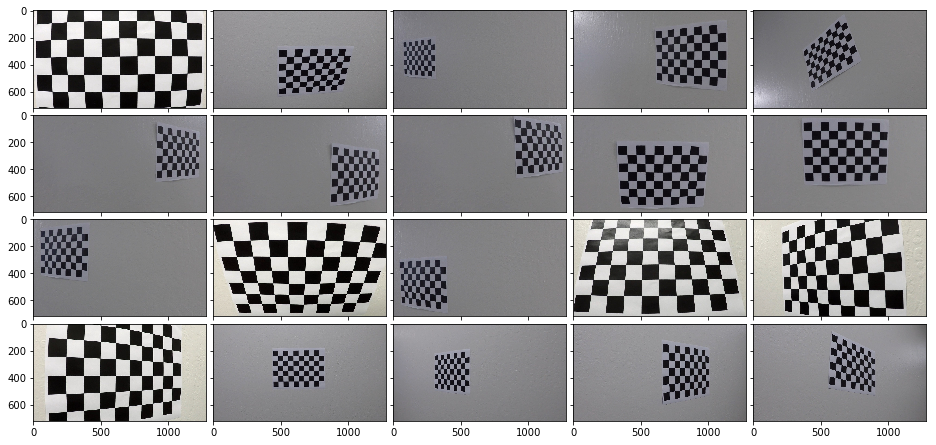

In [6]:
display(cal_images, cols=5)

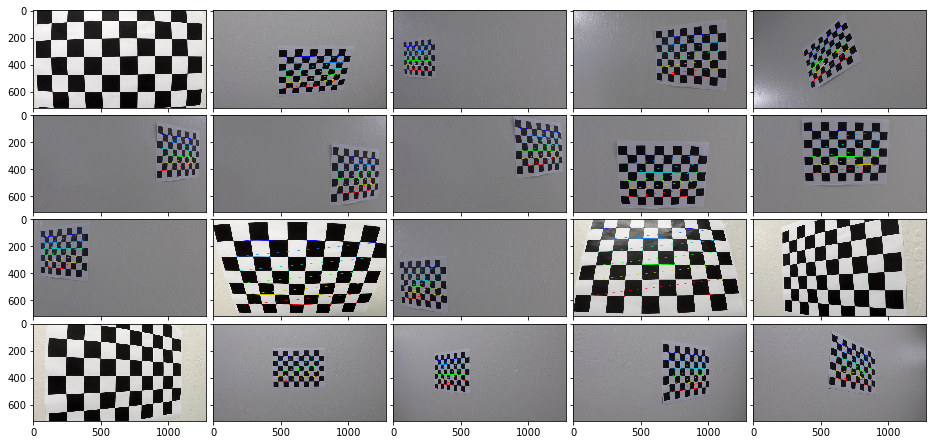

In [7]:
display(cal_chessboards, cols=5)

#### Chessboard discovery rate
As can be observed, chessboard corners could not be identified on all calibration images. This is due to the fact that we are looking for a `9 x 6` chessboard, but not all necessary intersections are visible on the images. The top left photo, for example, lacks the bottom row. The bottom left photo lacks the top left intersections of the chessboard. The 15th photo (row 3, column 5) misses th top right corner needed.

## Calibrating the Camera

With the help of the discovered chessboard corners in the section above, it is now possible to calibrate the camera, i.e. retrieve the camera's transformation matrix `M`.

In [8]:
M, dist = calibration.calibrate(cal_images)
print('Camera matrix:', M)
print('Distortion coefficients:', dist)

Camera matrix: [[  1.15396093e+03   0.00000000e+00   6.69705357e+02]
 [  0.00000000e+00   1.14802496e+03   3.85656234e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
Distortion coefficients: [[ -2.41017956e-01  -5.30721173e-02  -1.15810355e-03  -1.28318856e-04
    2.67125290e-02]]


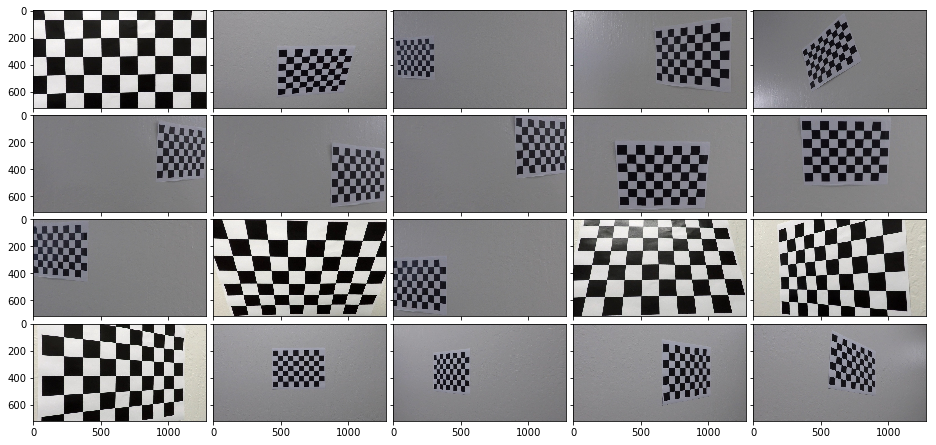

In [9]:
undist_images = [calibration.undistort(img, M, dist) for img in cal_images]
display(undist_images, cols=5)

### Comparing original and undistorted chessboard images

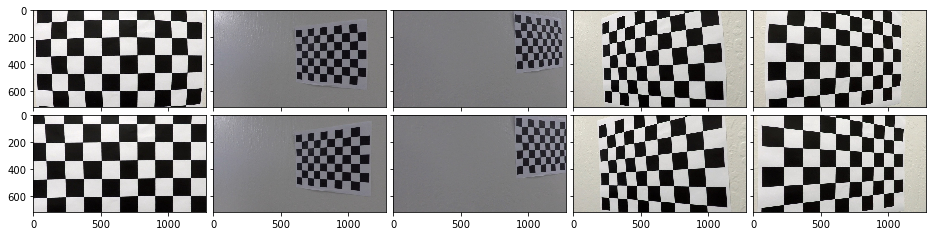

In [10]:
samples = (0, 3, 7, 14, 15)
compare = [z for i, z in enumerate(cal_images) if i in samples]
compare += [z for i, z in enumerate(undist_images) if i in samples]

display(compare, cols=5)

## Finding Gradients

In [11]:
TEST_IMAGE_FOLDER = 'test_images'
test_image_filenames = os.listdir(TEST_IMAGE_FOLDER)
print('Found {} test images: {}'.format(len(test_image_filenames), ', '.join(test_image_filenames)))
test_image_filenames = [os.path.join(TEST_IMAGE_FOLDER, fname) for fname in test_image_filenames]

Found 8 test images: straight_lines1.jpg, straight_lines2.jpg, test1.jpg, test2.jpg, test3.jpg, test4.jpg, test5.jpg, test6.jpg


In [12]:
test_images = [calibration.load_image(fname) for fname in test_image_filenames]

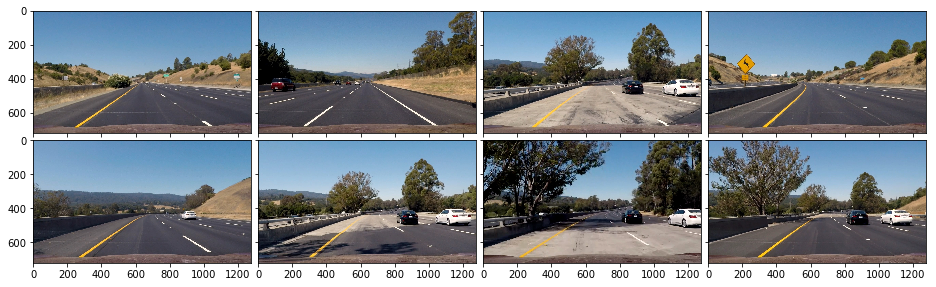

In [13]:
display(test_images, cols=len(test_images)//2)

In [14]:
import imp
imp.reload(sobel)

test_image_subset = test_images[:3]

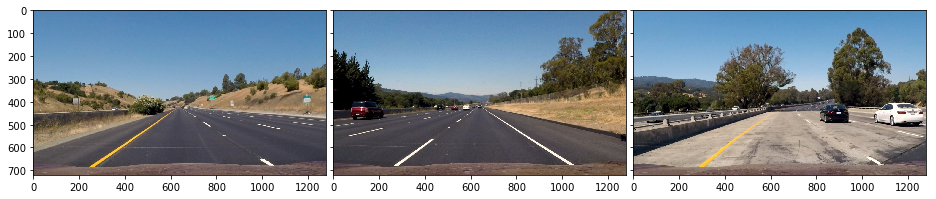

In [15]:
display(test_image_subset)

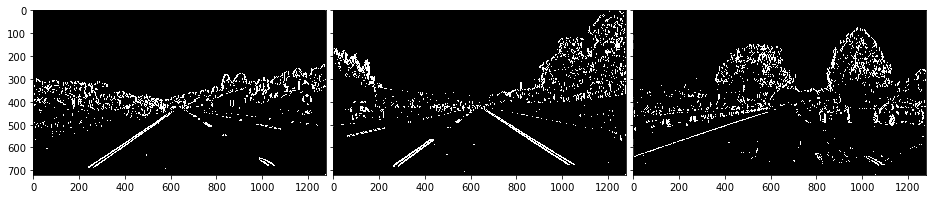

In [16]:
test_sobelx = [sobel.sobel(img, axis='x', threshold=(30,200), kernel=15) for img in test_image_subset]
display(test_sobelx)

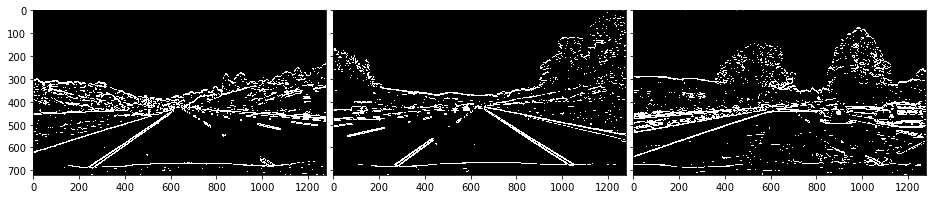

In [17]:
test_sobely = [sobel.sobel(img, axis='y', threshold=(30,200), kernel=15) for img in test_image_subset]
display(test_sobely)

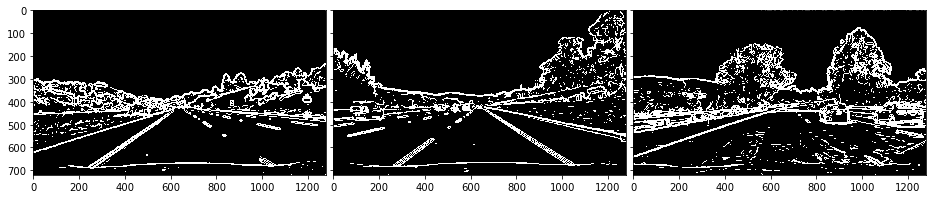

In [18]:
test_sobelxy = [sobel.sobel(img, axis='xy', threshold=(30,200), kernel=25) for img in test_image_subset]
display(test_sobelxy)

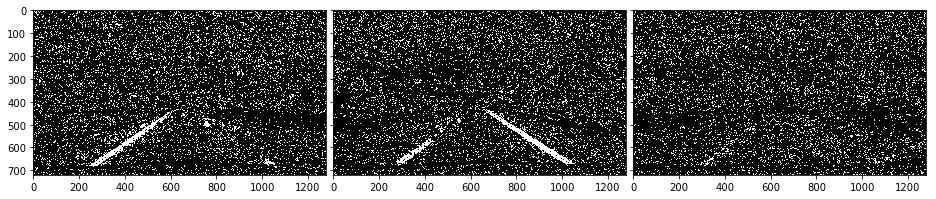

In [19]:
test_sobeld = [sobel.sobel(img, directional=True, threshold=(0.9,1.1), kernel=25) for img in test_image_subset]
display(test_sobeld)

## Color Channels

### RGB

In [20]:
def split_channels(images):
    result = []
    for img in images:
        for channel in cv2.split(img):
            result.append(channel)
    return result
            
def binary(images, channel, threshold=(150,255)):
    def _binary(image):
        c = cv2.split(image)[channel]
        b = np.zeros_like(c)
        b[(c >= threshold[0]) & (c <= threshold[1])] = 1
        return b
    if isinstance(images, list):
        return [_binary(img) for img in images]
    else:
        return _binary(images)

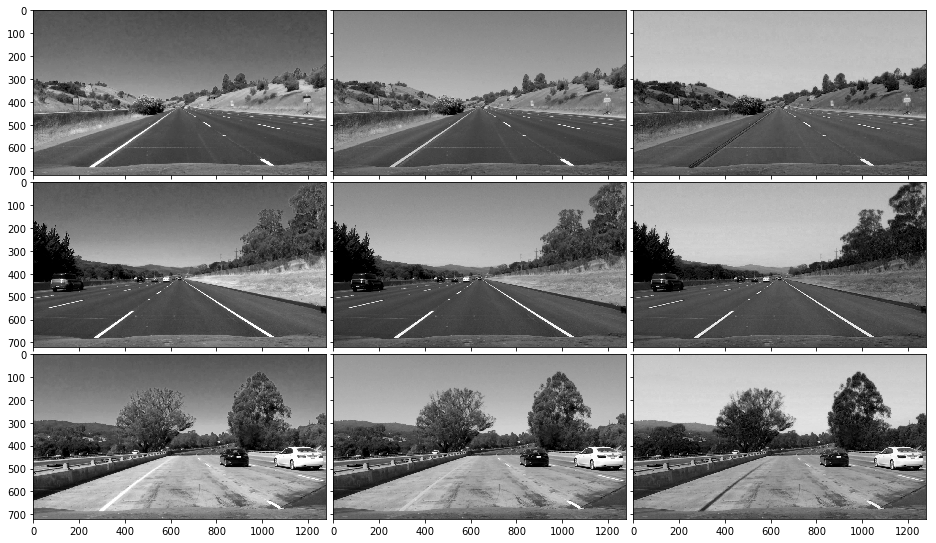

In [21]:
display( split_channels(test_image_subset), cols=3 )

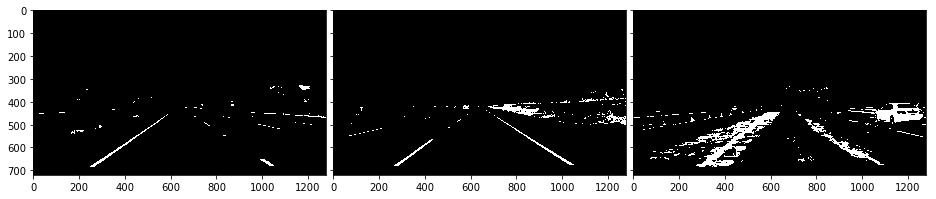

In [22]:
display( binary(test_image_subset, channel=0, threshold=(200, 255)) )

### HLS

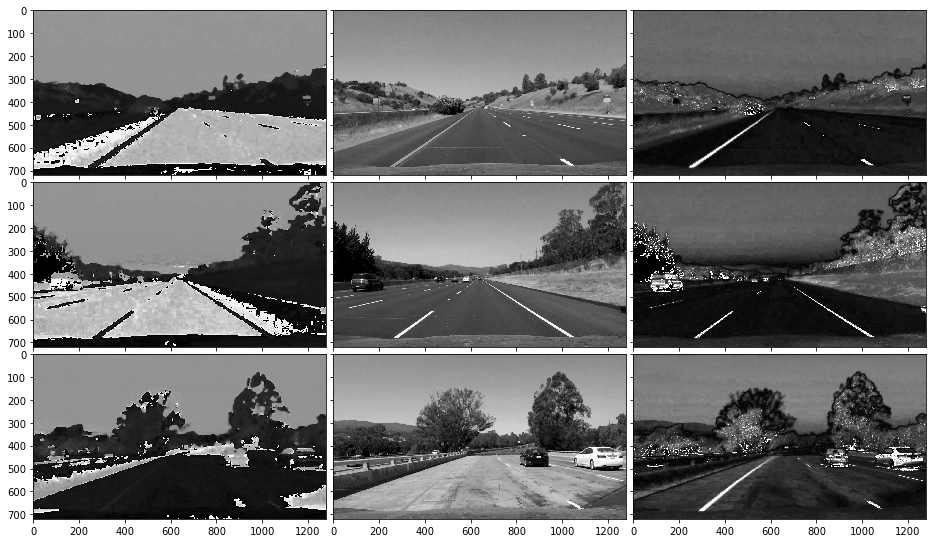

In [23]:
test_image_subset_hls = [cv2.cvtColor(img, cv2.COLOR_RGB2HLS) for img in test_image_subset]

display(split_channels(test_image_subset_hls), cols=3)

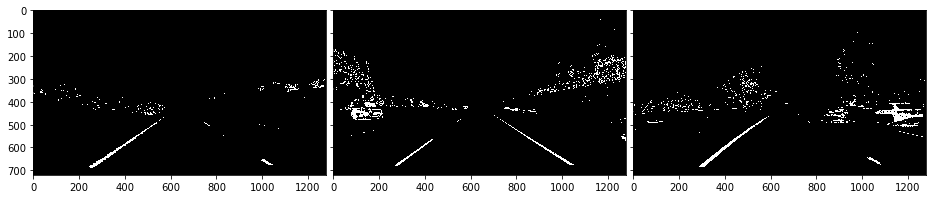

In [24]:
display( binary(test_image_subset_hls, channel=2, threshold=(150, 255)) )